In [8]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [9]:
#%% Import Class & Functions

from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Python')

# CNN Class
import Class.CNN as CNN

# Function
from Function.dSplit import dSplit
import Function.LossFunc as LF
import Function.myDataset as mD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


            Name               Size
0     Total data  (2000, 1, 91, 91)
1  Training data  (1584, 1, 91, 91)
2    Devset data   (396, 1, 91, 91)
3      Test data    (20, 1, 91, 91)


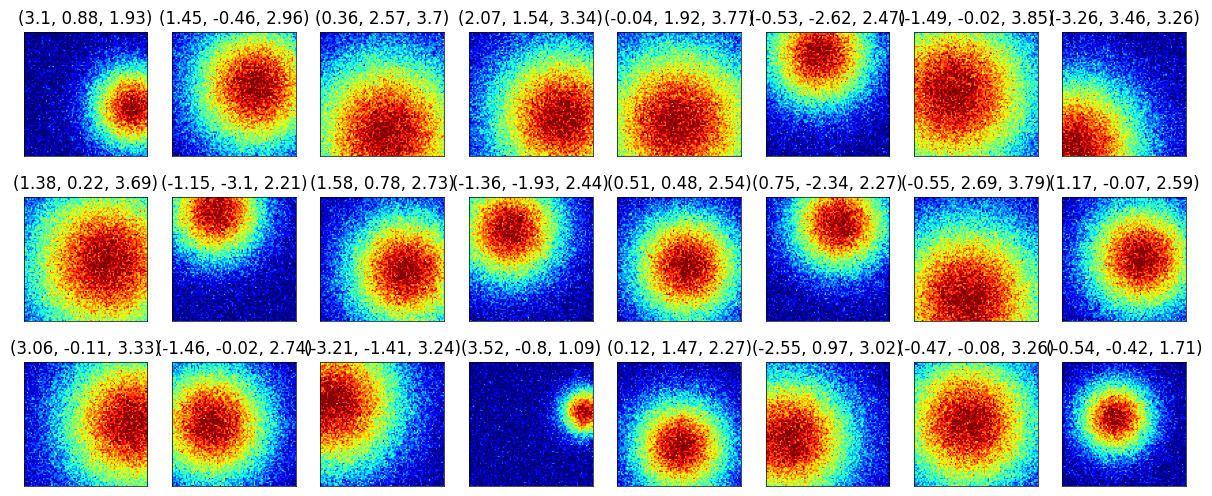

In [10]:
#%% Generate Gauss data

ndataClass = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)


# initialize tensors
imgDat = torch.zeros(2*ndataClass, 1, imgSize, imgSize)
labels = torch.zeros(2*ndataClass, 3)

# generate Guass data
for i in range(len(labels)):
    
    # center width
    cw = np.random.rand()*3 + 1
    
    # pick random centers
    C = 2*np.random.randn(2)
    
    # Guass equation
    G  = np.exp( -( (X-C[0])**2 + (Y-C[1])**2) / (2*cw**2) )
    
    # add random noise
    G  = G + np.random.randn(imgSize, imgSize)/10

    # store in tensors
    imgDat[i, 0, :, :] = torch.tensor(G)
    labels[i, :] = torch.tensor( [C[0], C[1], cw] )

# labels = labels.reshape(-1, 1)

# visualize some images
fig, axs = plt.subplots(3, 8, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    
    pic2show = np.random.randint(len(labels))
    G = np.squeeze( imgDat[pic2show, 0, :, :] )
    ax.imshow(G, vmin=0, vmax=1, cmap='jet')
    ax.set_title(f'{tuple(np.round(labels[pic2show, :].detach().numpy(), 2))}')
    ax.set_xticks([])
    ax.set_yticks([])
    
#%% divide independent set
data_ss, data_test_ind, y_ss, y_test_ind = train_test_split(imgDat, labels, test_size=0.01)


# independent test set
# convert to tensor
data_test_ind_ts = data_test_ind.float()
y_test_ind_ts = y_test_ind.float() # .long() (integer and for cross-entropy, multi class)
# y_test_ind_ts = y_test_ind_ts.reshape((-1, 1)).long() # .float() and reshape only for binary
# y_test_ind_ts = torch.tensor(y_test_ind).reshape((-1, 1)).float()

# convert to dataset and dataLoader
Dataset_test = TensorDataset(data_test_ind_ts, y_test_ind_ts)
DataLoader_test = DataLoader(Dataset_test, batch_size=Dataset_test.tensors[0].shape[0])

# %% train/dev dataset

# train set and dev set
# convert to tensor
data_ts = data_ss.float()
y_ts = y_ss.float() # .long() (integer and for cross-entropy, multi class)
# y_ts = y_ts.reshape((-1, 1)).long() # .float() and reshape only for binary
# y_ts = torch.tensor(y_ss).reshape((-1, 1)).float() # MSE (regression)

# params
dev_size = 0.2
b_size = 32

# train and dev set
DataLoader_train, DataLoader_dev, size = dSplit(data_ts, y_ts, model_test_size=dev_size, p_batch_size=b_size)


# # noise augmented set
# DataLoader_train_na, DataLoader_dev_na, _ = dSplit(data_ts_na, y_ts_na, model_test_size=test_size, p_batch_size=b_size)


# data size summary
d = {'Name': ['Total data', 'Training data', 'Devset data', 'Test data'],
     'Size': [imgDat.shape, size[0], size[1], data_test_ind_ts.shape]}

size_table = pd.DataFrame(data=d)
print(size_table)


# check data
# note: observe dataloader by iterate through them
# for X, y in DataLoader_train:
#   print(X.shape, y.shape)
# X, y

# X, y = next(iter(DataLoader_train))
# X, y


In [11]:
# %% Create/Train model

# experiment parameters
optimTypes = ['Adam']
# dataLoaderSet = [[DataLoader_train, DataLoader_dev], [DataLoader_train_na, DataLoader_dev_na]]
lr = [0.01]

model_params_0 = optimTypes
model_params_1 = lr

# model parameters
epochs = 20
dr = 0

# store result
# list_y_pred_params_0 = []
list_losses_train_params_0 = []
list_acc_ep_train_params_0 = []
list_acc_ep_test_params_0 = []
# list_w_histx_params_0 = []
list_w_histy_params_0 = []
# nParams     = np.zeros( (len(model_params_0), len(model_params_1)) )
time_proc = np.zeros((len(model_params_0), len(model_params_1)))

# store predicted data from trained model
list_y_pred_model_params_0 = []



# store the best trained model
bestModel = {'Accuracy':0,
             'net':None,
             'params': (None, None),
             }

# Layers inputs
convLayers = {
        'conv0': {
            'in_channels': 1,
            'out_channels': 6,
            'kernel_size': 3,
            'stride': 1, # default
            'padding': 1
            },
        'conv1': {
            'in_channels': 6,
            'out_channels': 4,
            'kernel_size': 3,
            'stride': 1, # default
            'padding': 1
            }
    }

poolLayers = {
        'pool0': {
            'kernel_size': 2,
            'stride': 2
            },
        'pool1': {
            'kernel_size': 2,
            'stride': 2
            }
        }

# hidden layer structure
hiddenLayers = {
        'hidden0': {
            'in_features': 50, 
            'out_features': 50
            },
        # 'hidden1': {
        #     'in_features': 50, 
        #     'out_features': 25
        #     },
    }



# run experiments
for (e, param_0) in enumerate(model_params_0):

    # store result
    res_losses_train = np.zeros((len(model_params_1), epochs))
    res_acc_ep_train = np.zeros((len(model_params_1), epochs))
    res_acc_ep_test = np.zeros((len(model_params_1), epochs))
    res_w_histx = np.zeros((epochs, 100, len(model_params_1)))
    res_w_histy = np.zeros((epochs, 100, len(model_params_1)))
    # res_y_pred_train = np.zeros( (batch_size, len(np.unique(labels)), len(model_params_1)) )
    
    # store predicted data from trained model
    y_pred_model = []

    for (i, param_1) in enumerate(model_params_1):

        # timer
        time_start = time.process_time()

        # Model class instance
        CNN_model = CNN.CNN_Class()
        
        # construct layers
        CNN_model.setLayers(imgSize=imgSize, 
                            convLayer=convLayers, 
                            poolLayer=poolLayers, 
                            hiddLayer=hiddenLayers,
                            feature_out=3, 
                            # printToggle=True
                            )
        
        # set parameters
        CNN_model.setParams(dropout_rate=0,
                            learning_rate=param_1,
                            act_lib='torch',
                            conv_activation_fun='relu',  # activation function at convolution layers (fully-connected layers)
                            pool_lib='torch.nn.functional',
                            pool_fun='avg_pool2d',
                            activation_fun='relu',  # activation function at hidden layers (fully-connected layers)
                            optim_fun=param_0,
                            save_FeatMap=True
                            )

        dataloader_dict = {
            'DataLoader_train': DataLoader_train,
            'DataLoader_test': DataLoader_dev,
            }

        # result during training per each epoch
        _, model_losses_train, model_acc_ep_train, model_acc_ep_test, _, model_w_histx, model_w_histy = CNN_model.trainModel(
            **dataloader_dict,
            epochs=epochs,
            loss_function='MSE',
            comp_acc_test=True,
            comp_w_hist=True,
            comp_w_change=False
        )

        res_losses_train[i, :] = model_losses_train.detach().numpy()

        res_acc_ep_train[i, :] = model_acc_ep_train.detach().numpy()

        # res_y_pred_train[:, :, i] = model_y_pred_train.detach().numpy()

        # accuracy comparing to test_set per each epoch
        res_acc_ep_test[i, :] = model_acc_ep_test.detach().numpy()

        # histogram weight
        res_w_histy[:, :, i] = model_w_histy

        # model parameters
        # nParams[e, i] = model_nParams

        # process time
        time_proc[e, i] = time.process_time() - time_start
        
        
    # Store result
    list_losses_train_params_0.append(res_losses_train)
    list_acc_ep_train_params_0.append(res_acc_ep_train)
    list_acc_ep_test_params_0.append(res_acc_ep_test)
    # list_w_histx_params_0.append(res_w_histx)
    list_w_histy_params_0.append(res_w_histy)
    # list_y_pred_params_0.append(res_y_pred_train)
    # list_y_pred_model_params_0.append(y_pred_model)
    
    # Store best model
    mean_acc = np.mean(list_acc_ep_test_params_0[-1][-1, :-5])
    if mean_acc > bestModel['Accuracy']:
        bestModel['Accuracy'] = mean_acc
        bestModel['net'] = copy.deepcopy(CNN_model.state_dict())
        bestModel['params'] = (e, i)

#%% check total number of parameters in the model
summary(CNN_model, (1, imgSize, imgSize))


Epoch 1/20. Test Acc = 0.23%
Time used: 2.35 sec

Epoch 2/20. Test Acc = 0.13%
Time used: 1.45 sec

Epoch 3/20. Test Acc = 0.11%
Time used: 1.48 sec

Epoch 4/20. Test Acc = 0.13%
Time used: 1.48 sec

Epoch 5/20. Test Acc = 0.08%
Time used: 1.47 sec

Epoch 6/20. Test Acc = 0.13%
Time used: 1.47 sec

Epoch 7/20. Test Acc = 0.07%
Time used: 1.46 sec

Epoch 8/20. Test Acc = 0.06%
Time used: 1.71 sec

Epoch 9/20. Test Acc = 0.06%
Time used: 2.18 sec

Epoch 10/20. Test Acc = 0.09%
Time used: 1.45 sec

Epoch 11/20. Test Acc = 0.06%
Time used: 1.44 sec

Epoch 12/20. Test Acc = 0.05%
Time used: 1.44 sec

Epoch 13/20. Test Acc = 0.07%
Time used: 1.47 sec

Epoch 14/20. Test Acc = 0.08%
Time used: 1.44 sec

Epoch 15/20. Test Acc = 0.05%
Time used: 1.44 sec

Epoch 16/20. Test Acc = 0.05%
Time used: 1.55 sec

Epoch 17/20. Test Acc = 0.06%
Time used: 2.20 sec

Epoch 18/20. Test Acc = 0.06%
Time used: 1.54 sec

Epoch 19/20. Test Acc = 0.06%
Time used: 1.45 sec

Epoch 20/20. Test Acc = 0.05%
Time used

Text(0, 0.5, 'Density')

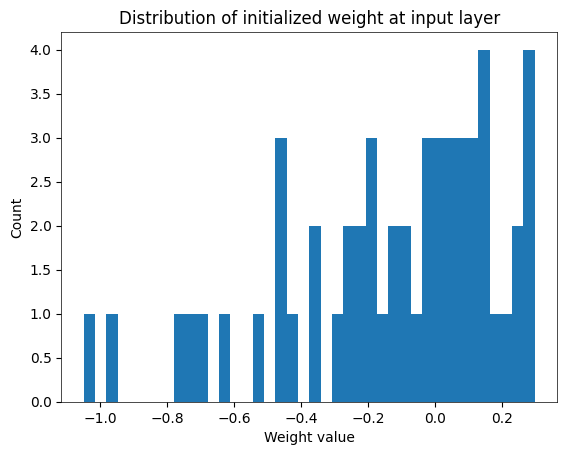

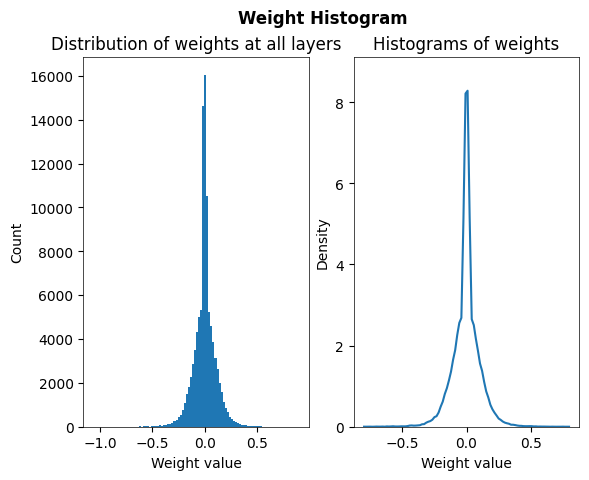

In [13]:
#%% explore the model's weight each layer

net_input_layer = vars(CNN_model.layers['conv0'])
net_input_layer_weight = CNN_model.layers['conv0'].weight

# plot histogram of weight
plt.figure()
plt.hist(net_input_layer_weight.detach().flatten(), 40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized weight at input layer')


# weight at all layers
W = np.array([])

# get set of weights from each layer
for layer in CNN_model.layers:
    W = np.concatenate((W, CNN_model.layers[f'{layer}'].weight.detach().flatten().numpy() ))

# compute histogram
histy, histx = np.histogram(W, bins=np.linspace(-.8, .8, 101), density=True)
histx = (histx[1:] + histx[:-1])/2 # correct the dimension

# plot
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'Weight Histogram', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)

plt.subplot(1, 2, 1)
# plot histogram of weight (bar)
plt.hist(W, bins=100)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of weights at all layers')

plt.subplot(1, 2, 2)
plt.plot(histx, histy)
plt.ylim([0, np.max(histy)*1.1])
plt.title('Histograms of weights')
plt.xlabel('Weight value')
plt.ylabel('Density')

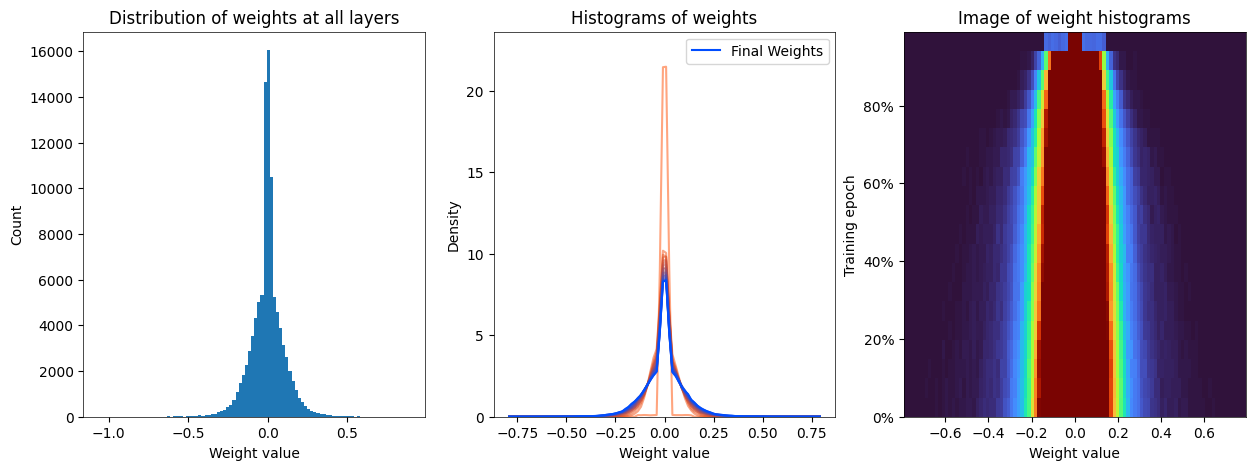

In [14]:
#%% Model's weight histogram of each epoch

# show the histogram of the weights

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

model_w_histy = list_w_histy_params_0[0][:, :, -1]

# plot histogram of weight (bar)
ax[0].hist(W, bins=100)
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of weights at all layers')


# plot histogram of weight (line)
w_len = len(model_w_histy)
for i in range(model_w_histy.shape[0]-1):
    ax[1].plot(model_w_histx, model_w_histy[i, :], color=[1-i/w_len, 0.3, i/w_len], alpha=0.5)
ax[1].plot(model_w_histx, model_w_histy[-1, :], color=[1-model_w_histy.shape[0]/w_len, 0.3, model_w_histy.shape[0]/w_len], label='Final Weights')
ax[1].set_title('Histograms of weights')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Density')
ax[1].legend()
ax[1].set_ylim([0, np.max(model_w_histy)*1.1])

# plot image of weight with epoch
ax[2].imshow(model_w_histy, vmin=0, vmax=0.8,
             extent=[model_w_histx[0], model_w_histx[-1], 0, 99], aspect='auto', origin='upper', cmap='turbo')
ax[2].set_xlabel('Weight value')
ax[2].set_ylabel('Training epoch')
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax[2].set_title('Image of weight histograms')

plt.show()

Text(0.5, 1.0, 'MSE Loss by Epoch(test set)')

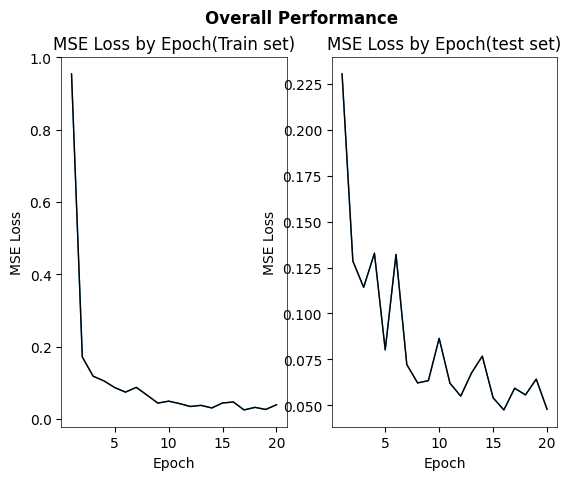

In [15]:
#%% plot model performance


# plot
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot train-test acc-epoch by model
# plt.figure()
plt.subplot(1, 2, 1)
y_plot_1 = np.array(list_losses_train_params_0[0]).T
y_plot_2 = np.mean(np.array(list_losses_train_params_0[0]), axis=0)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'MSE Loss by Epoch(Train set)')
# plt.legend([f'{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])

plt.subplot(1, 2, 2)
y_plot_1 = np.array(list_acc_ep_test_params_0[0]).T
y_plot_2 = np.mean(np.array(list_acc_ep_test_params_0[0]), axis=0)
# plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'MSE Loss by Epoch(test set)')
# plt.legend([f'{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])

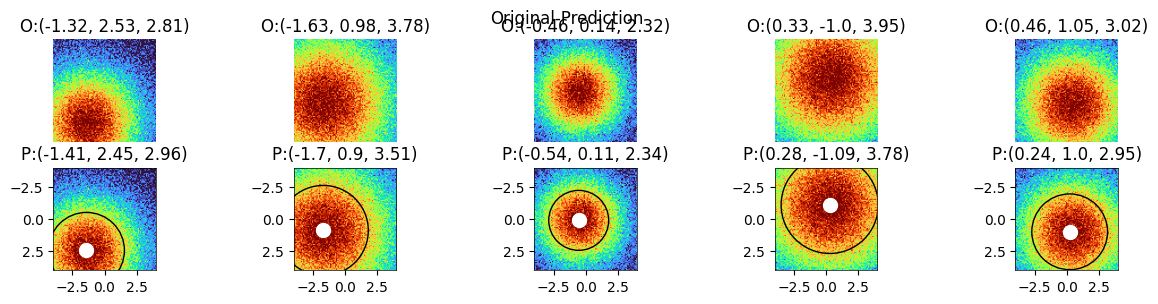

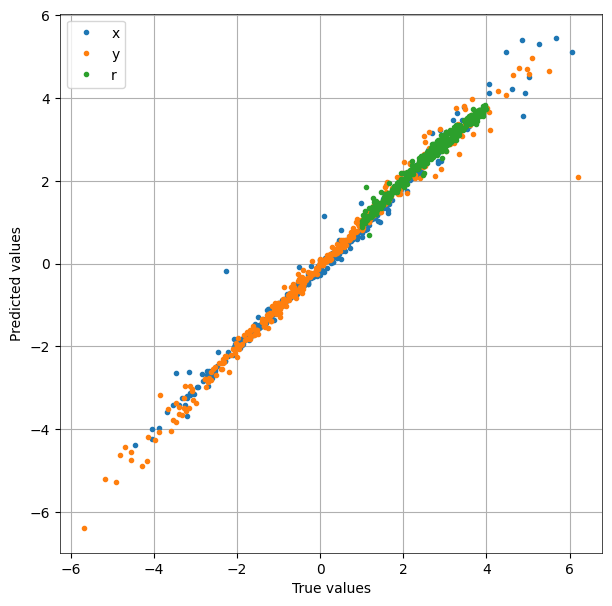

In [17]:
#%% Prediction from trained model

X, y = next(iter(DataLoader_dev))

# run the model through for the test data
# X = data_test_ind_ts[randId, :, :, :]
# y = y_test_ind_ts[randId, :]

# sample to show
nPic = 5
randId = np.random.choice(len(X), nPic, replace=False)

predictions, _ = CNN_model.predict(X, y)
# predicitons = torch.sigmoid(predictions)

fig, axs = plt.subplots(2, nPic, figsize=(15, 3))
fig.suptitle('Original-Prediction')

# original images from teh ind test set
for axi in range(len(randId)):
    
    axs[0, axi].imshow(X[randId[axi], 0, :, :], cmap='turbo', vmin=0, vmax=1)
    axs[0, axi].axis('off')
    axs[0, axi].set_title(f'O:{tuple(np.round(y[randId[axi], :].detach().numpy(), 2))}')
    
    axs[1, axi].imshow(X[randId[axi], 0, :, :], cmap='turbo', vmin=0, vmax=1, extent=[-4, 4, 4, -4])
    axs[1, axi].plot(predictions[randId[axi], 0].item(), predictions[randId[axi], 1].item(), 'wo', markersize=10)
    cir = plt.Circle((predictions[randId[axi], 0].item(), predictions[randId[axi], 1].item()), predictions[randId[axi], 2].item(), fill=False)
    axs[1, axi].add_artist(cir)
    # axs[1, axi].axis('off')
    axs[1, axi].set_title(f'P:{tuple(np.round(predictions[randId[axi], :].detach().numpy(), 2))}')

# plot raw data and prediction
fig = plt.figure(figsize=(7, 7))

for i in range(3):
  plt.plot(y[:, i].detach(), predictions[:, i].detach(), 'o', markersize=3)

plt.legend(['x', 'y', 'r'])
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()

Text(0.5, 0.98, '2nd convolution layer filters(kernels)')

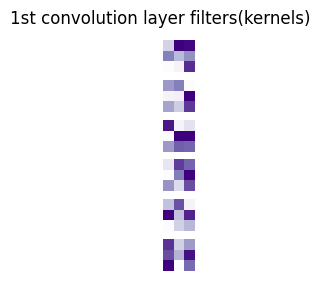

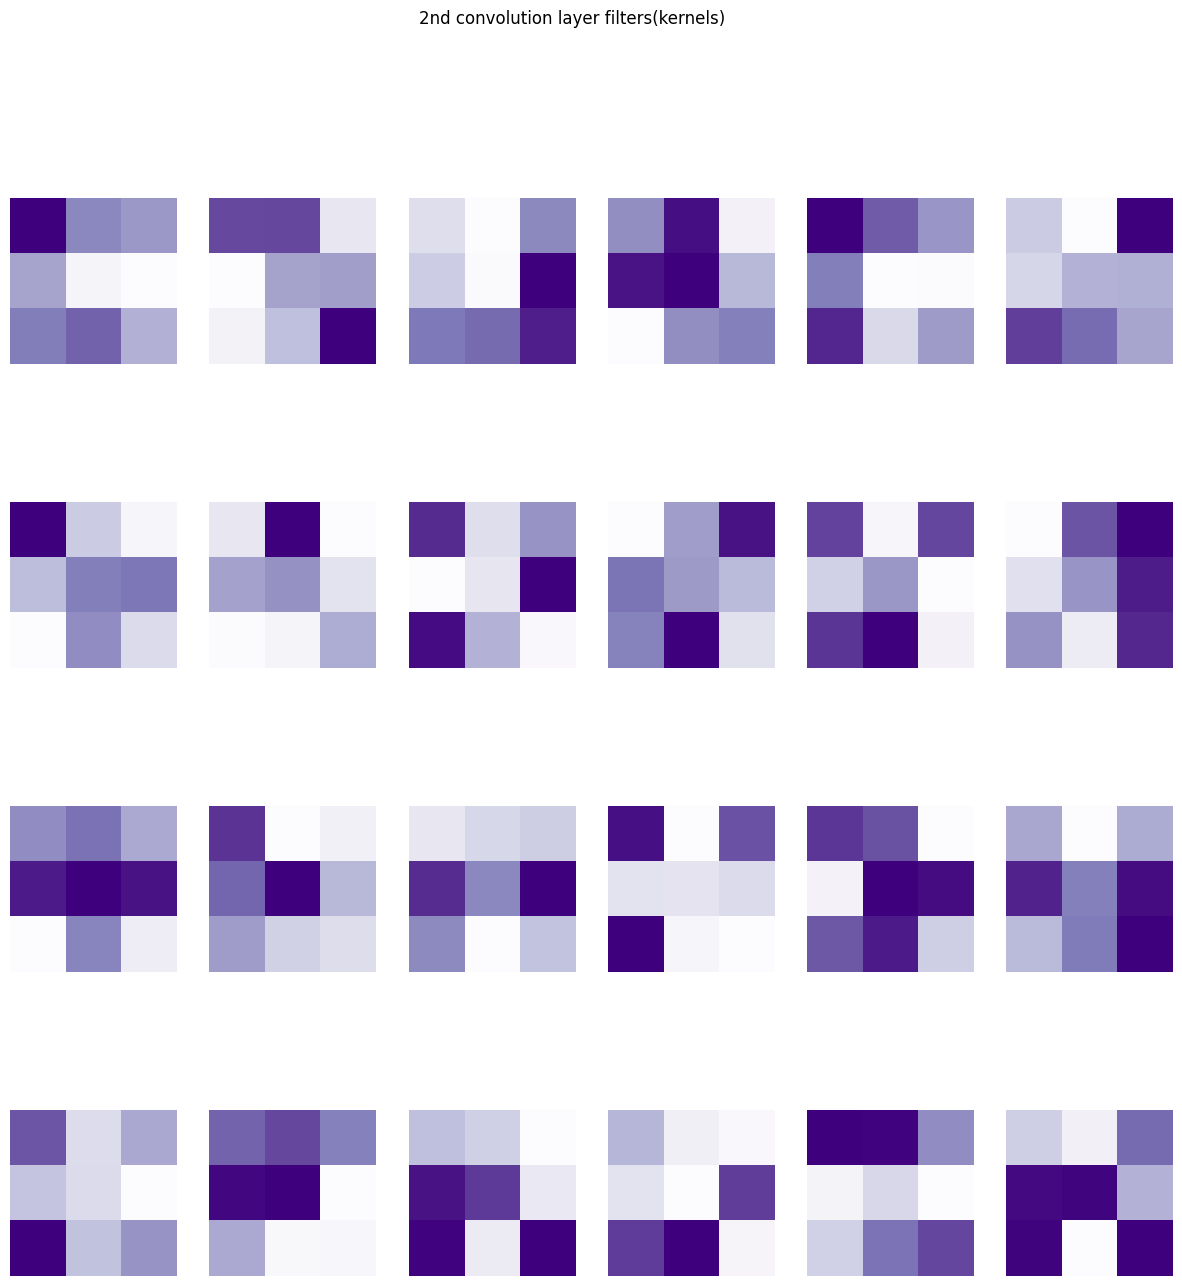

In [18]:
#%% explore the filter-kernel(weight) at convolution layer

# conv layer's weight
layerW1 = CNN_model.layers['conv0'].weight

fig, axs = plt.subplots(layerW1.shape[0], layerW1.shape[1], figsize=(15, 3))

for i, ax in enumerate(axs.flatten()):
    ax.imshow( torch.squeeze(layerW1[i, :, :, :]).detach() ,cmap='Purples')
    ax.axis('off')

plt.suptitle('1st convolution layer filters(kernels)')

# conv layer's weight
layerW2 = CNN_model.layers['conv1'].weight

fig, axs = plt.subplots( layerW2.shape[0], layerW2.shape[1], figsize=(15, 15))

for i, ax in enumerate(axs.flatten()):
    idx = np.unravel_index(i, (layerW2.shape[0], layerW2.shape[1]))
    ax.imshow( torch.squeeze(layerW2[idx[0], idx[1], :, :]).detach() ,cmap='Purples')
    ax.axis('off')

plt.suptitle('2nd convolution layer filters(kernels)')

Text(0.5, 0.98, '2nd convolution layer feature maps')

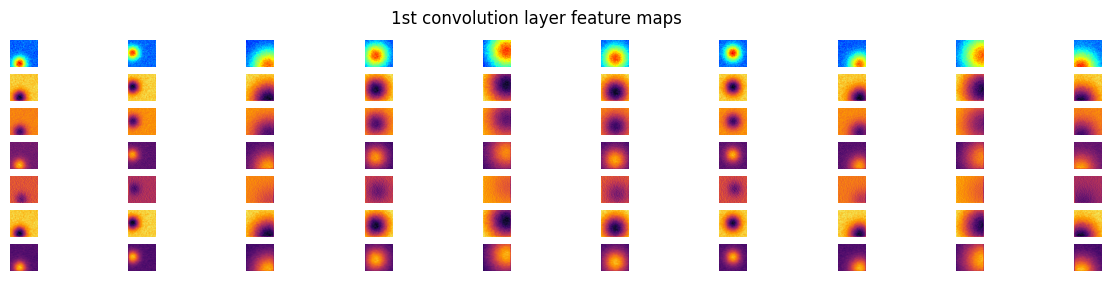

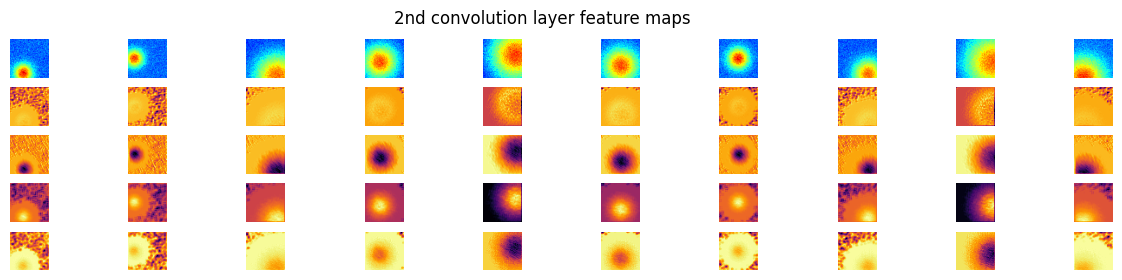

In [26]:
#%% explore the feature maps on independent test set

# ============================================================
# 1st conv layer's feature map
# ============================================================
fm = CNN_model.featureMaps['conv0']
fmSize = CNN_model.featureMaps['conv0'].shape

# plot 10 random images
nPic = 10
randId = np.random.choice(fmSize[0], nPic, replace=False)
fig, axs = plt.subplots(fmSize[1]+1, nPic, figsize=(15, 3))

# original images from teh ind test set
for axi, imgi in enumerate(randId):
    axs[0, axi].imshow(X[imgi, 0, :, :], cmap='jet') #vmin=0, vmax=1)
    axs[0, axi].axis('off')
    # axs[0, axi].text(2, 2, f'T:{y[imgi].int().item()} P:{predictions[imgi].int().item()}', ha='left', va='top', color='k', fontweight='bold', backgroundcolor='w')
    
    # its feature maps
    for k in range(fmSize[1]):
        img = fm[imgi, k, :, :]
        axs[k+1, axi].imshow(img, cmap='inferno') #vmin=0, vmax=torch.max(img)*0.9)
        axs[k+1, axi].axis('off')
        
plt.suptitle('1st convolution layer feature maps')

# ============================================================
# 2nd conv layer's feature map
# ============================================================
fm = CNN_model.featureMaps['conv1']
fmSize = CNN_model.featureMaps['conv1'].shape

fig, axs = plt.subplots(fmSize[1]+1, nPic, figsize=(15, 3))

# original images from teh ind test set
for axi, imgi in enumerate(randId):
    axs[0, axi].imshow(X[imgi, 0, :, :], cmap='jet') #vmin=0, vmax=1)
    axs[0, axi].axis('off')
    
    # its feature maps
    for k in range(fmSize[1]):
        img = fm[imgi, k, :, :]
        axs[k+1, axi].imshow(img, cmap='inferno') #vmin=0, vmax=torch.max(img)*0.9)
        axs[k+1, axi].axis('off')
        # axs[0, axi].text(2, 2, f'T:{y[imgi].int().item()} P:{predictions[imgi].int().item()}', ha='left', va='top', color='k', fontweight='bold', backgroundcolor='w')

plt.suptitle('2nd convolution layer feature maps')



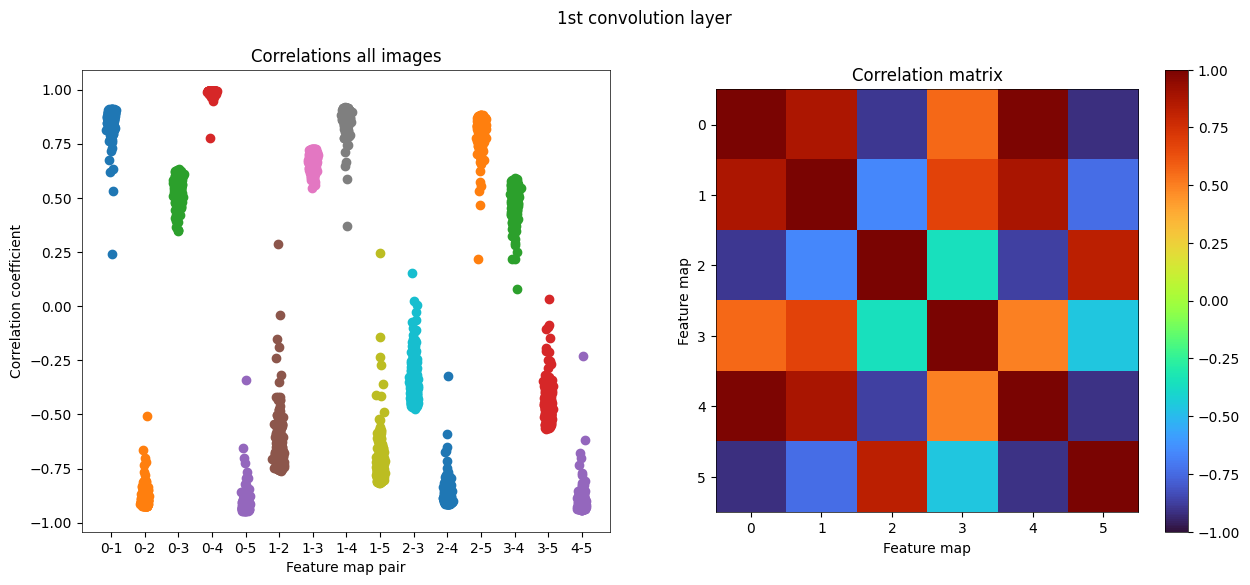

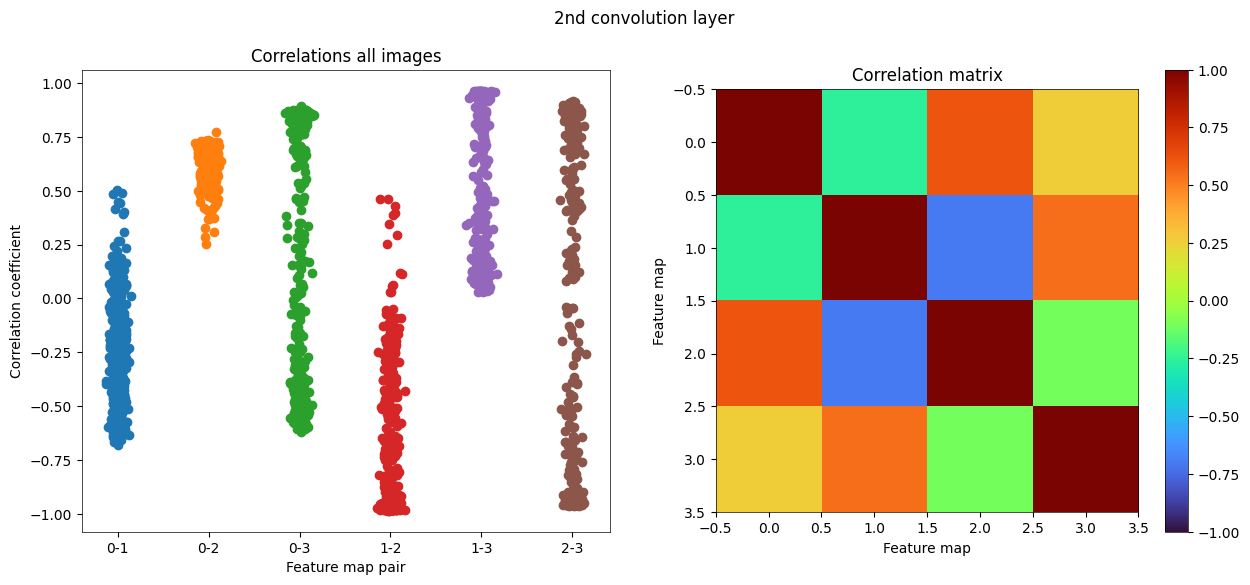

In [22]:
#%% Correlation of the feature maps

# ============================================================
# 1st convolution layer
# ============================================================
fm = CNN_model.featureMaps['conv0']

# cal number of pair
nImgs = fm.shape[0]
nMaps = fm.shape[1]
nP = (nMaps*(nMaps-1))//2 # number of pairs [0-1], [0-2], [1-2]

# initialze the matrix
all_rs = np.zeros((nImgs, nP))
C_all  = np.zeros((nMaps, nMaps))

for i in range(nImgs):
    
    # extract the vectorized feature maps from this image
    featmaps = fm[i, :, :, :].view(nMaps, -1).detach()
    
    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    C_all += C
    
    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C, 1)) # tuple
    all_rs[i, :] = C[idx]


# generate the x-axis labels
xlab = []
for i in range(nP):
    xlab.append(f'{idx[0][i]}-{idx[1][i]}')


# plot corrcoef
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
plt.suptitle('1st convolution layer')

# plot all pairs of correlation
for i in range(nP):
    axs[0].plot(i+np.random.randn(nImgs)*0.05, all_rs[:, i], 'o')
axs[0].set_xlabel('Feature map pair')
axs[0].set_xticks(range(nP))
axs[0].set_xticklabels(xlab)
axs[0].set_ylabel('Correlation coefficient')
axs[0].set_title('Correlations all images')

# now show the average correlation matrix
avg_cm = axs[1].imshow(C_all/nImgs, vmin=-1, vmax=1, cmap='turbo')
axs[1].set_title('Correlation matrix')
axs[1].set_xlabel('Feature map')
axs[1].set_ylabel('Feature map')
fig.colorbar(avg_cm, ax=axs[1])

# ============================================================
# 2nd convolution layer
# ============================================================
fm = CNN_model.featureMaps['conv1']

# cal number of pair
nImgs = fm.shape[0]
nMaps = fm.shape[1]
nP = (nMaps*(nMaps-1))//2 # number of pairs [0-1], [0-2], [1-2]

# initialze the matrix
all_rs = np.zeros((nImgs, nP))
C_all  = np.zeros((nMaps, nMaps))

for i in range(nImgs):
    
    # extract the vectorized feature maps from this image
    featmaps = fm[i, :, :, :].view(nMaps, -1).detach()
    
    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    C_all += C
    
    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C, 1)) # tuple
    all_rs[i, :] = C[idx]


# generate the x-axis labels
xlab = []
for i in range(nP):
    xlab.append(f'{idx[0][i]}-{idx[1][i]}')


# plot corrcoef
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
plt.suptitle('2nd convolution layer')

# plot all pairs of correlation
for i in range(nP):
    axs[0].plot(i+np.random.randn(nImgs)*0.05, all_rs[:, i], 'o')
axs[0].set_xlabel('Feature map pair')
axs[0].set_xticks(range(nP))
axs[0].set_xticklabels(xlab)
axs[0].set_ylabel('Correlation coefficient')
axs[0].set_title('Correlations all images')

# now show the average correlation matrix
avg_cm = axs[1].imshow(C_all/nImgs, vmin=-1, vmax=1, cmap='turbo')
axs[1].set_title('Correlation matrix')
axs[1].set_xlabel('Feature map')
axs[1].set_ylabel('Feature map')
fig.colorbar(avg_cm, ax=axs[1])